### This notebook is to tune the MLP model used for artificial data, and the HIV dataset.

In [2]:
from utils import gen_data, BH, Bonferroni
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt

In [137]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import Adam

In [165]:
class MLP_l1(nn.Module):
    def __init__(self, input_dim=20, output_dim=1, hidden_layer_sizes=[32,] * 2, lr=1e-4, alpha=3e-2):
        super().__init__()
        self.hidden = list(hidden_layer_sizes)
        self.lr = lr
        self.alpha = alpha

        self.dimensions = [input_dim] + self.hidden + [output_dim]
        modules = []
        for i in range(len(self.dimensions) - 1):
            modules.append(nn.Linear(self.dimensions[i], self.dimensions[i+1]))
            modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*modules)

        self.optimizer = Adam(self.parameters(), lr=lr)
    
    def predict(self, X):
        return self.mlp(X)

    def forward(self, X):
        return self.mlp(X)

    def partial_fit(self, X, y):
        y_pred = self.predict(X)
        loss = F.mse_loss(y.unsqueeze(1), y_pred)
        l1_reg = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                l1_reg += torch.linalg.norm(param, 1)
        total_loss = loss + l1_reg * self.alpha

        # print(loss, l1_reg)

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

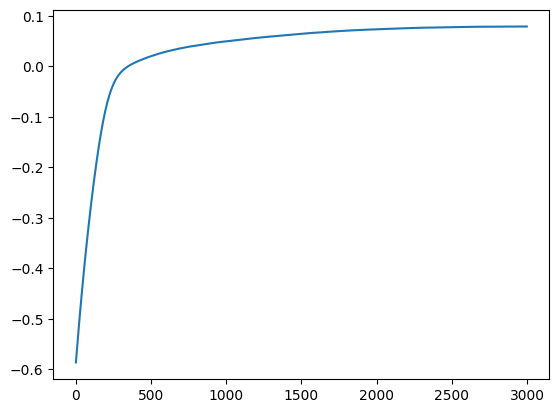

In [177]:
setting = 5 # 1 ~ 8

N = 1000
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

Xtrain = torch.tensor(Xtrain).double()
Xvalid = torch.tensor(Xvalid).double()
Ytrain = torch.tensor(Ytrain).double()

mlp = MLP_l1(hidden_layer_sizes=(32, ) * 2, alpha=3e-2, lr=1e-4).double()

r2 = []

for epoch in range(3000):
    mlp.partial_fit(Xtrain, (Ytrain > 0).double())
    
    Ypred = mlp.predict(Xvalid).detach().numpy()
    r2.append(r2_score(Yvalid > 0, Ypred))

plt.plot(r2)
plt.show()

In [149]:
setting = 5 # 1 ~ 8

N = 1000
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=3e-2, learning_rate_init=1e-4)

r2 = []

for epoch in range(3000):
    mlp.partial_fit(Xtrain, Ytrain > 0)
    
    Ypred = mlp.predict(Xvalid)
    r2.append(r2_score(Yvalid > 0, Ypred))

c:\Users\Tian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


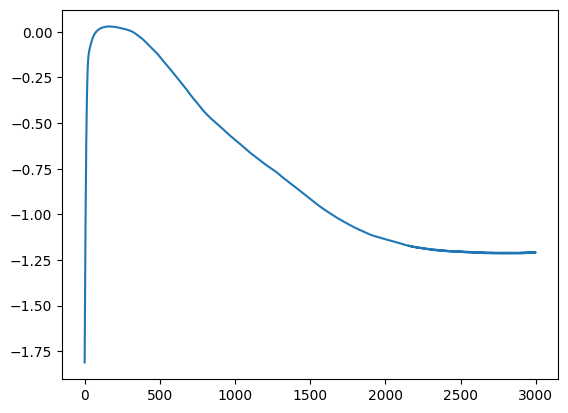

In [152]:
plt.plot(r2)
plt.show()

-0.04187540254624045


ValueError: x, y, and format string must not be None

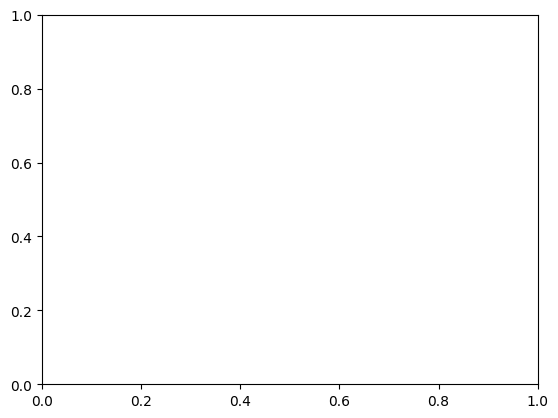

In [108]:
N = 1000
setting = 5
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 2, random_state=0, alpha=3e-2, learning_rate_init=1e-4, max_iter=500)
mlp.fit(Xtrain, Ytrain > 0)
Ypred = mlp.predict(Xvalid)
print(r2_score(Yvalid > 0, Ypred))
plt.plot(mlp.validation_scores_)
plt.show()